# Test cases to compare GPPR vs DBO

### Import Statements

In [19]:
import time
import pandas as pd
import matplotlib.pyplot as plt

%run "Finance_Management_GPPR.ipynb"
%run "Finance_Management_DBO.ipynb"

=== GPPR Budget Result ===
Category        Spend s[i]   Min m[i]   Priority  Budget b[i]    Cut (s-b)
--------------------------------------------------------------------------
Rent               1200.00    1200.00          1      1200.00         0.00
Groceries           400.00     300.00          2       300.00       100.00
Restaurants         350.00     100.00          4       214.53       135.47
Transport           150.00     100.00          3       113.87        36.13
Entertainment       200.00      50.00          5       126.60        73.40

Diagnostics:
           algorithm: GPPR
 discretionary_total: 550.0
feasible_full_target: True
           ops_count: 67
adjustment_iterations: 1
          runtime_ms: 0.0
         total_spend: 2300.0
        total_budget: 1955.0
       target_budget: 1955.0
        required_cut: 345.0
          actual_cut: 345.0
        target_error: 0.0
              min_ok: True
      target_reached: True
=== DBO Budget Result ===
Category        Spend s[i] 

### Helper Functions

In [20]:
def compute_priority_cut_stats(s, b, p, high_priority_threshold=2):
    """
    Compute average percentage cut for high-priority vs low-priority categories.

    high_priority_threshold:
        categories with p <= threshold are considered 'high priority',
        others are 'low priority'.
    """
    n = len(s)
    cuts = [s[i] - b[i] for i in range(n)]
    percent_cuts = []
    for i in range(n):
        if s[i] > 0:
            percent_cuts.append(cuts[i] / s[i])
        else:
            percent_cuts.append(0.0)

    high_cuts = []
    low_cuts = []
    for i in range(n):
        if p[i] <= high_priority_threshold:
            high_cuts.append(percent_cuts[i])
        else:
            low_cuts.append(percent_cuts[i])

    avg_high = sum(high_cuts) / len(high_cuts) if high_cuts else 0.0
    avg_low = sum(low_cuts) / len(low_cuts) if low_cuts else 0.0

    return {
        "avg_cut_high_priority": avg_high,
        "avg_cut_low_priority": avg_low,
    }

In [21]:
def run_algorithm_on_case(case_name, case_data, algo_name):
    """
    Run either GPPR or DBO on a single test case and collect metrics.

    algo_name: "GPPR" or "DBO"
    """
    s = case_data["s"]
    m = case_data["m"]
    p = case_data["p"]
    r = case_data["r"]
    unit = case_data["unit"]
    categories = case_data["categories"]

    if algo_name == "GPPR":
        b, diag = gppr_budget(s, m, p, r, adjustment_unit=unit)
    elif algo_name == "DBO":
        b, diag = dbo_budget(s, m, p, r, unit=unit)
    else:
        raise ValueError(f"Unknown algorithm: {algo_name}")

    # Basic metrics are already inside diag (from compute_basic_metrics)
    priority_stats = compute_priority_cut_stats(s, b, p)

    row = {
        "case_name": case_name,
        "description": case_data["description"],
        "algorithm": algo_name,
        "total_spend": diag["total_spend"],
        "target_budget": diag["target_budget"],
        "total_budget": diag["total_budget"],
        "required_cut": diag["required_cut"],
        "actual_cut": diag["actual_cut"],
        "target_error": diag["target_error"],
        "min_ok": diag["min_ok"],
        "target_reached": diag["target_reached"],
        "runtime_ms": diag.get("runtime_ms", None),
        "ops_count": diag.get("ops_count", None),
        "feasible_full_target": diag.get("feasible_full_target", None),
    }

    # Add algorithm-specific diagnostics if present
    if algo_name == "GPPR":
        row["discretionary_total"] = diag.get("discretionary_total", None)
        row["adjustment_iterations"] = diag.get("adjustment_iterations", None)
        row["dp_states"] = None  # not applicable
        row["required_cut_units"] = None
        row["max_total_units"] = None
    elif algo_name == "DBO":
        row["discretionary_total"] = None
        row["adjustment_iterations"] = None
        row["dp_states"] = diag.get("dp_states", None)
        row["required_cut_units"] = diag.get("required_cut_units", None)
        row["max_total_units"] = diag.get("max_total_units", None)

    # Priority stats
    row.update(priority_stats)

    return row

In [22]:
def run_case_full(case_name):
    """
    For a given test case, run both algorithms and return
    per-category data + diagnostics.
    """
    case = TEST_CASES[case_name]
    s = case["s"]
    m = case["m"]
    p = case["p"]
    r = case["r"]
    unit = case["unit"]
    categories = case["categories"]

    # GPPR
    b_gppr, diag_gppr = gppr_budget(s, m, p, r, adjustment_unit=unit)
    # DBO
    b_dbo, diag_dbo = dbo_budget(s, m, p, r, unit=unit)

    n = len(s)
    if not categories or len(categories) != n:
        categories = [f"C{i+1}" for i in range(n)]

    per_cat_rows = []
    for i in range(n):
        cut_gppr = s[i] - b_gppr[i]
        cut_dbo = s[i] - b_dbo[i]
        pct_gppr = cut_gppr / s[i] if s[i] > 0 else 0.0
        pct_dbo = cut_dbo / s[i] if s[i] > 0 else 0.0

        per_cat_rows.append({
            "Category": categories[i],
            "Priority": p[i],
            "Spend": s[i],
            "Min": m[i],
            "GPPR_budget": b_gppr[i],
            "GPPR_cut": cut_gppr,
            "GPPR_cut_pct": pct_gppr,
            "DBO_budget": b_dbo[i],
            "DBO_cut": cut_dbo,
            "DBO_cut_pct": pct_dbo,
        })

    per_cat_df = pd.DataFrame(per_cat_rows)

    return per_cat_df, diag_gppr, diag_dbo

In [23]:
def make_summary_table(case_name, diag_gppr, diag_dbo):
    """
    Build a compact summary table comparing GPPR vs DBO for one test case.
    """
    rows = []
    for algo, diag in [("GPPR", diag_gppr), ("DBO", diag_dbo)]:
        rows.append({
            "Algorithm": algo,
            "Total spend": diag["total_spend"],
            "Target budget": diag["target_budget"],
            "Actual budget": diag["total_budget"],
            "Required cut": diag["required_cut"],
            "Actual cut": diag["actual_cut"],
            "Target error": diag["target_error"],
            "Min OK": diag["min_ok"],
            "Target reached": diag["target_reached"],
            "Runtime (ms)": diag.get("runtime_ms", None),
        })
    df = pd.DataFrame(rows).set_index("Algorithm")

    # Simple styling for nicer screenshot
    styled = (df.style
              .format("{:.2f}", subset=pd.IndexSlice[:, ["Total spend", "Target budget",
                                                        "Actual budget", "Required cut",
                                                        "Actual cut", "Target error",
                                                        "Runtime (ms)"]])
              .highlight_min(subset=["Target error"], color="#d4f4dd")
              .highlight_max(subset=["Target error"], color="#f4d4d4"))
    return styled

### Test Cases Definition

In [24]:
# Test cases for the budget allocation algorithms.
# Each test case contains:
#   description, categories, s, m, p, r, unit

TEST_CASES = {
    # 1) No savings requested (r = 0) – should produce no cuts
    "no_savings": {
        "description": "No savings requested (r=0), budgets should match spends respecting minimums.",
        "categories": ["Rent", "Groceries", "Restaurants", "Transport", "Entertainment"],
        "s": [1200.0, 400.0, 350.0, 150.0, 200.0],
        "m": [1200.0, 300.0, 100.0, 100.0, 50.0],
        "p": [1, 2, 3, 3, 4],
        "r": 0.0,
        "unit": 10.0,
    },

    # 2) Equal priorities – simple proportional cuts
    "equal_priorities": {
        "description": "All categories have equal priority; expect roughly proportional cuts.",
        "categories": ["A", "B", "C", "D"],
        "s": [500.0, 300.0, 200.0, 100.0],
        "m": [100.0, 50.0, 20.0, 10.0],
        "p": [3, 3, 3, 3],      # equal priorities
        "r": 0.20,              # 20% savings
        "unit": 10.0,
    },

    # 3) Savings exceed discretionary (minimums bind)
    "min_bounds": {
        "description": "Required savings exceed total discretionary; algorithms must cut to minimums and still miss target.",
        "categories": ["X", "Y", "Z"],
        "s": [100.0, 80.0, 60.0],
        "m": [90.0, 70.0, 50.0],    # discretionary = 10 + 10 + 10 = 30
        "p": [2, 3, 4],
        "r": 0.50,                  # total=240, target=120, required cut=120 > 30
        "unit": 10.0,
    },

    # 4) Priority protection – high vs low priority
    "priority_protection": {
        "description": "One high-priority and one low-priority category; low-priority should face deeper cuts.",
        "categories": ["Essentials", "Luxury"],
        "s": [800.0, 800.0],
        "m": [700.0, 100.0],
        "p": [1, 5],                # Essentials more protected
        "r": 0.25,                  # total=1600, target=1200, required cut=400
        "unit": 10.0,
    },

    # 5) Larger mixed case – for performance and behavior on bigger input
    "large_mixed": {
        "description": "Larger example with mixed priorities and minimums for performance/behavior comparison.",
        "categories": [f"C{i+1}" for i in range(10)],
        "s": [400.0, 250.0, 300.0, 150.0, 220.0,
              500.0, 130.0, 180.0, 260.0, 90.0],
        "m": [300.0, 150.0, 150.0, 100.0, 150.0,
              400.0, 80.0, 100.0, 180.0, 50.0],
        "p": [1, 2, 3, 3, 4,
              2, 5, 4, 3, 5],
        "r": 0.18,                  # about 18% savings target
        "unit": 10.0,
    },
}

len(TEST_CASES)

5

### Executing Test Cases

In [25]:
rows = []

for case_name, case_data in TEST_CASES.items():
    # Run GPPR
    row_gppr = run_algorithm_on_case(case_name, case_data, "GPPR")
    rows.append(row_gppr)

    # Run DBO
    row_dbo = run_algorithm_on_case(case_name, case_data, "DBO")
    rows.append(row_dbo)

df_results = pd.DataFrame(rows)
df_results

,case_name,description,algorithm,total_spend,target_budget,total_budget,required_cut,actual_cut,target_error,min_ok,...,runtime_ms,ops_count,feasible_full_target,discretionary_total,adjustment_iterations,dp_states,required_cut_units,max_total_units,avg_cut_high_priority,avg_cut_low_priority
0,no_savings,"No savings requested (r=0), budgets should mat...",GPPR,2300.0,2300.0,2300.0,0.0,0.0,0.0,True,...,0.000000,5,True,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000
1,no_savings,"No savings requested (r=0), budgets should mat...",DBO,2300.0,2300.0,2300.0,0.0,0.0,0.0,True,...,0.000000,5,True,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000
2,equal_priorities,All categories have equal priority; expect rou...,GPPR,1100.0,880.0,880.0,220.0,220.0,0.0,True,...,0.000000,53,True,920.0,0.0,NaN,NaN,NaN,0.000000,0.205254
3,equal_priorities,All categories have equal priority; expect rou...,DBO,1100.0,880.0,880.0,220.0,220.0,0.0,True,...,1.657724,1536,True,NaN,NaN,115.0,22.0,92.0,0.000000,0.110000
4,min_bounds,Required savings exceed total discretionary; a...,GPPR,240.0,120.0,210.0,120.0,30.0,90.0,True,...,0.000000,9,False,30.0,0.0,NaN,NaN,NaN,0.100000,0.145833
5,min_bounds,Required savings exceed total discretionary; a...,DBO,240.0,120.0,210.0,120.0,30.0,90.0,True,...,0.000000,12,False,NaN,NaN,0.0,12.0,3.0,0.100000,0.145833
6,priority_protection,One high-priority and one low-priority categor...,GPPR,1600.0,1200.0,1200.0,400.0,400.0,0.0,True,...,0.000000,69,True,800.0,7.0,NaN,NaN,NaN,0.125000,0.375000
7,priority_protection,One high-priority and one low-priority categor...,DBO,1600.0,1200.0,1200.0,400.0,400.0,0.0,True,...,0.000000,832,True,NaN,NaN,123.0,40.0,80.0,0.125000,0.375000
8,large_mixed,Larger example with mixed priorities and minim...,GPPR,2480.0,2033.6,2033.6,446.4,446.4,0.0,True,...,0.000000,149,True,820.0,1.0,NaN,NaN,NaN,0.211303,0.166736
9,large_mixed,Larger example with mixed priorities and minim...,DBO,2480.0,2033.6,2030.0,446.4,450.0,-3.6,True,...,1.075029,5484,True,NaN,NaN,506.0,45.0,82.0,0.283333,0.071429


In [26]:
df_results_sorted = df_results.sort_values(by=["case_name", "algorithm"]).reset_index(drop=True)
df_results_sorted

,case_name,description,algorithm,total_spend,target_budget,total_budget,required_cut,actual_cut,target_error,min_ok,...,runtime_ms,ops_count,feasible_full_target,discretionary_total,adjustment_iterations,dp_states,required_cut_units,max_total_units,avg_cut_high_priority,avg_cut_low_priority
0,equal_priorities,All categories have equal priority; expect rou...,DBO,1100.0,880.0,880.0,220.0,220.0,0.0,True,...,1.657724,1536,True,NaN,NaN,115.0,22.0,92.0,0.000000,0.110000
1,equal_priorities,All categories have equal priority; expect rou...,GPPR,1100.0,880.0,880.0,220.0,220.0,0.0,True,...,0.000000,53,True,920.0,0.0,NaN,NaN,NaN,0.000000,0.205254
2,large_mixed,Larger example with mixed priorities and minim...,DBO,2480.0,2033.6,2030.0,446.4,450.0,-3.6,True,...,1.075029,5484,True,NaN,NaN,506.0,45.0,82.0,0.283333,0.071429
3,large_mixed,Larger example with mixed priorities and minim...,GPPR,2480.0,2033.6,2033.6,446.4,446.4,0.0,True,...,0.000000,149,True,820.0,1.0,NaN,NaN,NaN,0.211303,0.166736
4,min_bounds,Required savings exceed total discretionary; a...,DBO,240.0,120.0,210.0,120.0,30.0,90.0,True,...,0.000000,12,False,NaN,NaN,0.0,12.0,3.0,0.100000,0.145833
5,min_bounds,Required savings exceed total discretionary; a...,GPPR,240.0,120.0,210.0,120.0,30.0,90.0,True,...,0.000000,9,False,30.0,0.0,NaN,NaN,NaN,0.100000,0.145833
6,no_savings,"No savings requested (r=0), budgets should mat...",DBO,2300.0,2300.0,2300.0,0.0,0.0,0.0,True,...,0.000000,5,True,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000
7,no_savings,"No savings requested (r=0), budgets should mat...",GPPR,2300.0,2300.0,2300.0,0.0,0.0,0.0,True,...,0.000000,5,True,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000
8,priority_protection,One high-priority and one low-priority categor...,DBO,1600.0,1200.0,1200.0,400.0,400.0,0.0,True,...,0.000000,832,True,NaN,NaN,123.0,40.0,80.0,0.125000,0.375000
9,priority_protection,One high-priority and one low-priority categor...,GPPR,1600.0,1200.0,1200.0,400.0,400.0,0.0,True,...,0.000000,69,True,800.0,7.0,NaN,NaN,NaN,0.125000,0.375000


In [32]:
for case_name in TEST_CASES.keys():
    sub = df_results_sorted[df_results_sorted["case_name"] == case_name]
    print(f"\n=== Case: {case_name} ===")
    print(TEST_CASES[case_name]["description"])
    print(sub[[
        "algorithm",
        "total_spend",
        "target_budget",
        "total_budget",
        "required_cut",
        "actual_cut",
        "target_error",
        "runtime_ms",
        "avg_cut_high_priority",
        "avg_cut_low_priority",
        "min_ok",
        "target_reached",
    ]])


=== Case: no_savings ===
No savings requested (r=0), budgets should match spends respecting minimums.
  algorithm  total_spend  target_budget  total_budget  required_cut  \
6       DBO       2300.0         2300.0        2300.0           0.0   
7      GPPR       2300.0         2300.0        2300.0           0.0   

   actual_cut  target_error  runtime_ms  avg_cut_high_priority  \
6         0.0           0.0         0.0                    0.0   
7         0.0           0.0         0.0                    0.0   

   avg_cut_low_priority  min_ok  target_reached  
6                   0.0    True            True  
7                   0.0    True            True  

=== Case: equal_priorities ===
All categories have equal priority; expect roughly proportional cuts.
  algorithm  total_spend  target_budget  total_budget  required_cut  \
0       DBO       1100.0          880.0         880.0         220.0   
1      GPPR       1100.0          880.0         880.0         220.0   

   actual_cut  tar

### Saving Results

In [33]:
df_results_sorted.to_csv("budget_algorithms_results.csv", index=False)
print("Saved results to budget_algorithms_results.csv")

Saved results to budget_algorithms_results.csv


### Visualization Helpers

In [34]:
def plot_spend_vs_budgets(case_name, per_cat_df):
    """
    Bar chart: original spend vs GPPR & DBO budgets for each category.
    """
    cats = per_cat_df["Category"].tolist()
    s = per_cat_df["Spend"].tolist()
    b_gppr = per_cat_df["GPPR_budget"].tolist()
    b_dbo = per_cat_df["DBO_budget"].tolist()

    x = range(len(cats))
    width = 0.25

    plt.figure(figsize=(8, 4))
    plt.bar([xi - width for xi in x], s, width=width, label="Spend")
    plt.bar(x, b_gppr, width=width, label="GPPR budget")
    plt.bar([xi + width for xi in x], b_dbo, width=width, label="DBO budget")

    plt.xticks(list(x), cats, rotation=30, ha="right")
    plt.ylabel("Amount")
    plt.title(f"{case_name}: Spend vs Budgets")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [35]:
def plot_cut_percentages(case_name, per_cat_df):
    """
    Bar chart: percentage cut per category (GPPR vs DBO).
    """
    cats = per_cat_df["Category"].tolist()
    pct_gppr = [v * 100 for v in per_cat_df["GPPR_cut_pct"].tolist()]
    pct_dbo = [v * 100 for v in per_cat_df["DBO_cut_pct"].tolist()]

    x = range(len(cats))
    width = 0.25

    plt.figure(figsize=(8, 4))
    plt.bar([xi - width/2 for xi in x], pct_gppr, width=width, label="GPPR cut %")
    plt.bar([xi + width/2 for xi in x], pct_dbo, width=width, label="DBO cut %")

    plt.xticks(list(x), cats, rotation=30, ha="right")
    plt.ylabel("Cut (%)")
    plt.title(f"{case_name}: Percentage Cuts by Category")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
def show_case_report(case_name):
    """
    Generate one report page for the given test case:
      - description
      - summary table
      - spend vs budgets chart
      - cut% chart
      - short textual inference
    """
    case = TEST_CASES[case_name]
    print(f"=== Test case: {case_name} ===")
    print(case["description"])
    print()

    # Run algorithms & get per-category info
    per_cat_df, diag_gppr, diag_dbo = run_case_full(case_name)

    # 1) Summary table
    display(make_summary_table(case_name, diag_gppr, diag_dbo))

    # 2) Charts
    plot_spend_vs_budgets(case_name, per_cat_df)
    plot_cut_percentages(case_name, per_cat_df)

    # 3) Short inference text (you can copy this into your report)
    print("\nInference notes:")
    print(
        f"- Total spend = {diag_gppr['total_spend']:.2f}, "
        f"target budget = {diag_gppr['target_budget']:.2f}."
    )
    print(
        f"- GPPR: actual budget {diag_gppr['total_budget']:.2f}, "
        f"target error {diag_gppr['target_error']:.2f}, "
        f"target_reached={diag_gppr['target_reached']}."
    )
    print(
        f"- DBO : actual budget {diag_dbo['total_budget']:.2f}, "
        f"target error {diag_dbo['target_error']:.2f}, "
        f"target_reached={diag_dbo['target_reached']}."
    )

    # Priority behavior high-level note
    mask_high = per_cat_df["Priority"] <= 2
    mask_low = per_cat_df["Priority"] > 2

    if mask_high.any():
        avg_high_gppr = per_cat_df.loc[mask_high, "GPPR_cut_pct"].mean()
        avg_high_dbo = per_cat_df.loc[mask_high, "DBO_cut_pct"].mean()
    else:
        avg_high_gppr = 0.0
        avg_high_dbo = 0.0

    if mask_low.any():
        avg_low_gppr = per_cat_df.loc[mask_low, "GPPR_cut_pct"].mean()
        avg_low_dbo = per_cat_df.loc[mask_low, "DBO_cut_pct"].mean()
    else:
        avg_low_gppr = 0.0
        avg_low_dbo = 0.0

    print(
        f"- GPPR average cut%: high priority = {avg_high_gppr * 100:.2f}%, "
        f"low priority = {avg_low_gppr * 100:.2f}%."
    )
    print(
        f"- DBO  average cut%: high priority = {avg_high_dbo * 100:.2f}%, "
        f"low priority = {avg_low_dbo * 100:.2f}%.\n"
    )

### Generating Report

=== Test case: no_savings ===
No savings requested (r=0), budgets should match spends respecting minimums.



,Total spend,Target budget,Actual budget,Required cut,Actual cut,Target error,Min OK,Target reached,Runtime (ms)
Algorithm,,,,,,,,,
GPPR,2300.00,2300.00,2300.00,0.00,0.00,0.00,True,True,0.00
DBO,2300.00,2300.00,2300.00,0.00,0.00,0.00,True,True,0.00


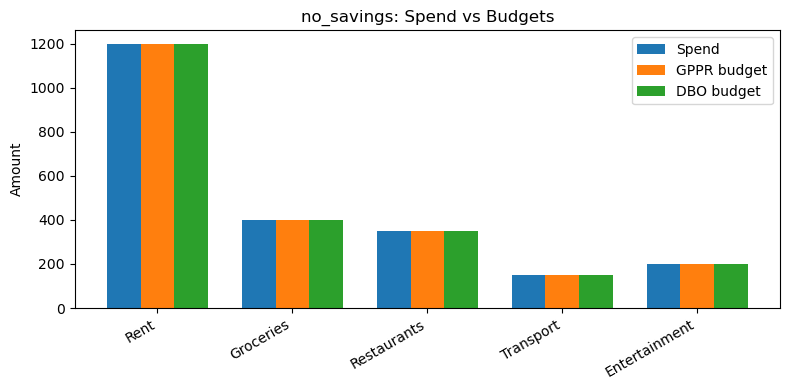

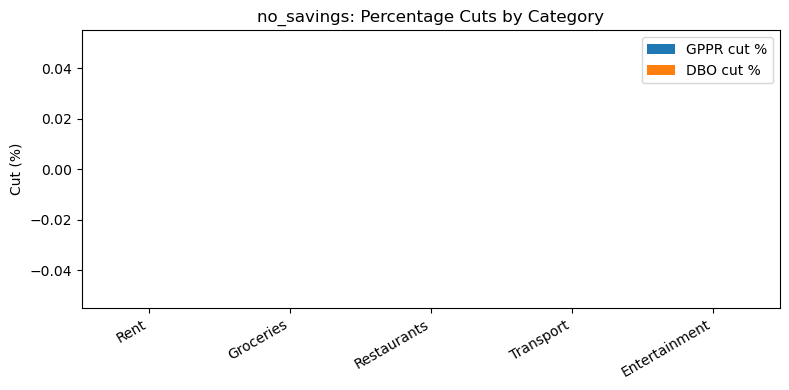


Inference notes:
- Total spend = 2300.00, target budget = 2300.00.
- GPPR: actual budget 2300.00, target error 0.00, target_reached=True.
- DBO : actual budget 2300.00, target error 0.00, target_reached=True.
- GPPR average cut%: high priority = 0.00%, low priority = 0.00%.
- DBO  average cut%: high priority = 0.00%, low priority = 0.00%.



=== Test case: equal_priorities ===
All categories have equal priority; expect roughly proportional cuts.



,Total spend,Target budget,Actual budget,Required cut,Actual cut,Target error,Min OK,Target reached,Runtime (ms)
Algorithm,,,,,,,,,
GPPR,1100.00,880.00,880.00,220.00,220.00,0.00,True,True,0.00
DBO,1100.00,880.00,880.00,220.00,220.00,0.00,True,True,0.00


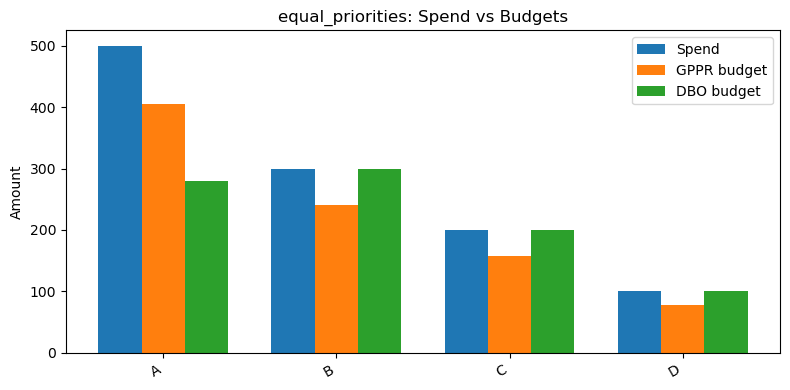

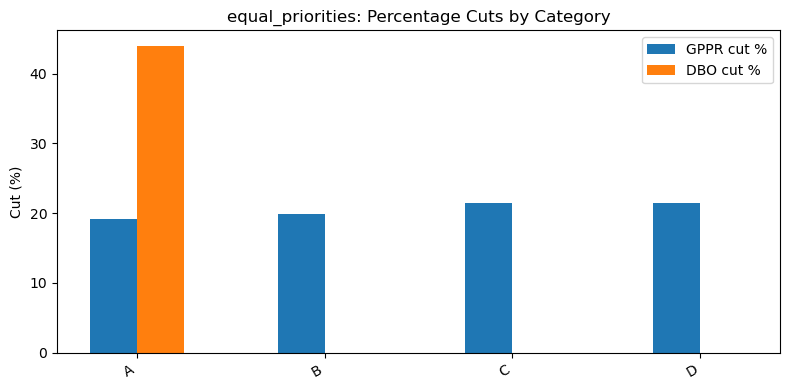


Inference notes:
- Total spend = 1100.00, target budget = 880.00.
- GPPR: actual budget 880.00, target error 0.00, target_reached=True.
- DBO : actual budget 880.00, target error 0.00, target_reached=True.
- GPPR average cut%: high priority = 0.00%, low priority = 20.53%.
- DBO  average cut%: high priority = 0.00%, low priority = 11.00%.



=== Test case: min_bounds ===
Required savings exceed total discretionary; algorithms must cut to minimums and still miss target.



,Total spend,Target budget,Actual budget,Required cut,Actual cut,Target error,Min OK,Target reached,Runtime (ms)
Algorithm,,,,,,,,,
GPPR,240.00,120.00,210.00,120.00,30.00,90.00,True,False,0.00
DBO,240.00,120.00,210.00,120.00,30.00,90.00,True,False,0.00


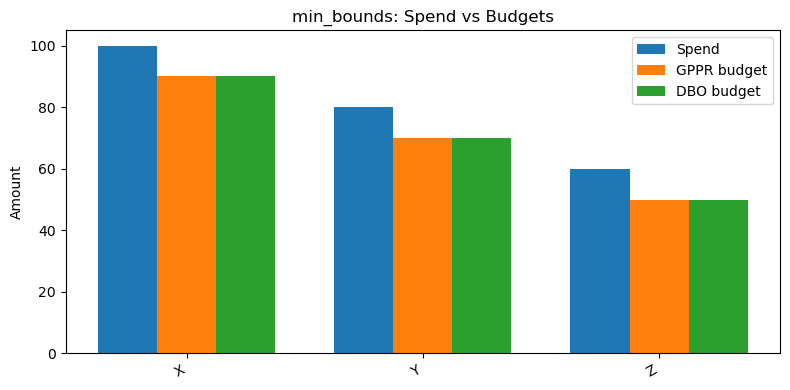

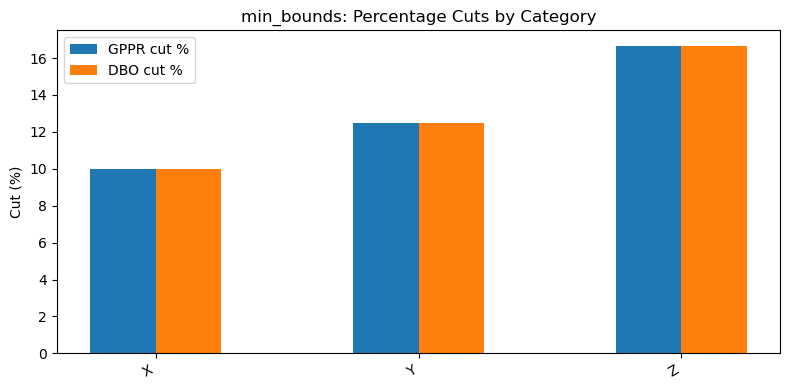


Inference notes:
- Total spend = 240.00, target budget = 120.00.
- GPPR: actual budget 210.00, target error 90.00, target_reached=False.
- DBO : actual budget 210.00, target error 90.00, target_reached=False.
- GPPR average cut%: high priority = 10.00%, low priority = 14.58%.
- DBO  average cut%: high priority = 10.00%, low priority = 14.58%.



=== Test case: priority_protection ===
One high-priority and one low-priority category; low-priority should face deeper cuts.



,Total spend,Target budget,Actual budget,Required cut,Actual cut,Target error,Min OK,Target reached,Runtime (ms)
Algorithm,,,,,,,,,
GPPR,1600.00,1200.00,1200.00,400.00,400.00,0.00,True,True,0.00
DBO,1600.00,1200.00,1200.00,400.00,400.00,0.00,True,True,1.00


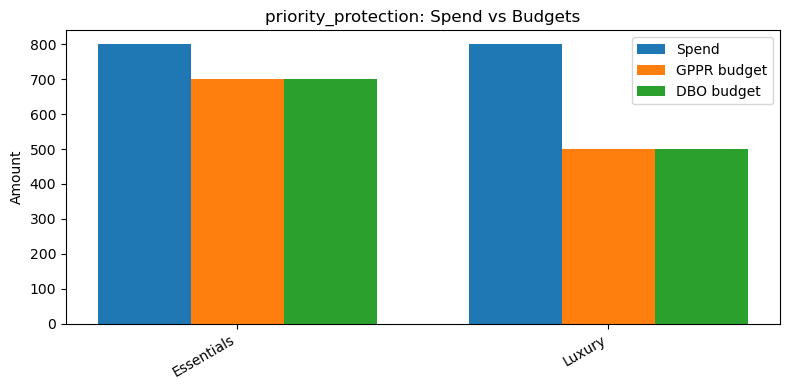

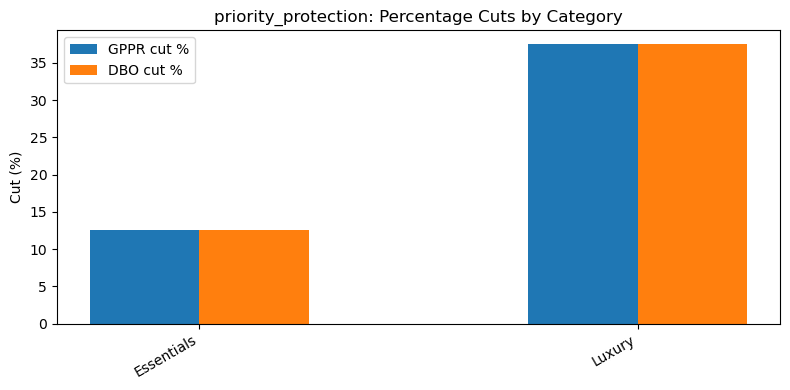


Inference notes:
- Total spend = 1600.00, target budget = 1200.00.
- GPPR: actual budget 1200.00, target error 0.00, target_reached=True.
- DBO : actual budget 1200.00, target error 0.00, target_reached=True.
- GPPR average cut%: high priority = 12.50%, low priority = 37.50%.
- DBO  average cut%: high priority = 12.50%, low priority = 37.50%.



=== Test case: large_mixed ===
Larger example with mixed priorities and minimums for performance/behavior comparison.



,Total spend,Target budget,Actual budget,Required cut,Actual cut,Target error,Min OK,Target reached,Runtime (ms)
Algorithm,,,,,,,,,
GPPR,2480.00,2033.60,2033.60,446.40,446.40,0.00,True,True,0.00
DBO,2480.00,2033.60,2030.00,446.40,450.00,-3.60,True,True,1.00


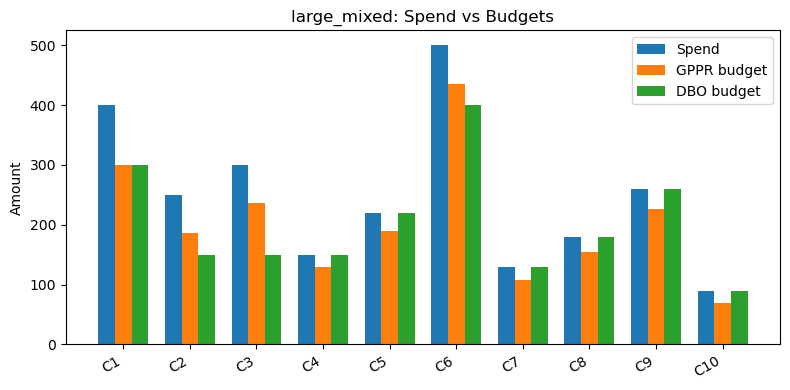

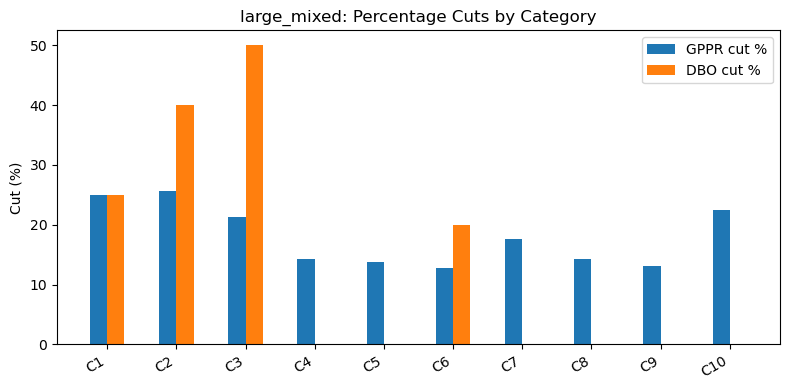


Inference notes:
- Total spend = 2480.00, target budget = 2033.60.
- GPPR: actual budget 2033.60, target error 0.00, target_reached=True.
- DBO : actual budget 2030.00, target error -3.60, target_reached=True.
- GPPR average cut%: high priority = 21.13%, low priority = 16.67%.
- DBO  average cut%: high priority = 28.33%, low priority = 7.14%.





In [37]:
for name in TEST_CASES.keys():
    show_case_report(name)
    print("\n" + "="*80 + "\n")